# Case Study 2 : Data Science in Yelp Data

**Required Readings:** 
* [Yelp Dataset Challenge](https://www.yelp.com/dataset_challenge) 
* Please download the Yelp dataset from the above webpage.

** NOTE **
* Please don't forget to save the notebook frequently when working in Jupyter Notebook, otherwise the changes you made can be lost.

*----------------------

Here is an example of the data format. More details are included [here](https://www.yelp.com/dataset_challenge)

## Business Objects

Business objects contain basic information about local businesses. The fields are as follows:

```json
{
  'type': 'business',
  'business_id': (a unique identifier for this business),
  'name': (the full business name),
  'neighborhoods': (a list of neighborhood names, might be empty),
  'full_address': (localized address),
  'city': (city),
  'state': (state),
  'latitude': (latitude),
  'longitude': (longitude),
  'stars': (star rating, rounded to half-stars),
  'review_count': (review count),
  'photo_url': (photo url),
  'categories': [(localized category names)]
  'open': (is the business still open for business?),
  'schools': (nearby universities),
  'url': (yelp url)
}
```
## Checkin Objects
```json
{
    'type': 'checkin',
    'business_id': (encrypted business id),
    'checkin_info': {
        '0-0': (number of checkins from 00:00 to 01:00 on all Sundays),
        '1-0': (number of checkins from 01:00 to 02:00 on all Sundays),
        ...
        '14-4': (number of checkins from 14:00 to 15:00 on all Thursdays),
        ...
        '23-6': (number of checkins from 23:00 to 00:00 on all Saturdays)
    }, # if there was no checkin for a hour-day block it will not be in the dict
}
```

# Problem: pick a data science problem that you plan to solve using Yelp Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using yelp data and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?


IDEAS:

* look at businesses near universities look at atributes that appeal to college students 
	* ambient noise level
	* distance from university
	* low cost
	* open late
	* good for groups
	* happy hour
	* NOT good for kids
* Figure out popularity based on number of checkins
	* Popular resturants can have a bigger dot on the map

* Use PCA/Random Forest predictions to get feature importances of "popular" resturants in a college town


# Data Collection/Processing: 

In [9]:
#----------------------------------------------
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

import json

# The business data
with open('yelp_academic_dataset_business.json') as f:
    business_data = []
    for line in f:
        business_data.append(json.loads(line))

# The checkin data
with open('yelp_academic_dataset_checkin.json') as f:
    checkin_data = []
    for line in f:
        checkin_data.append(json.loads(line))


        
# Simple check that all data was loaded
print(len(business_data))
print(len(checkin_data))


188593
157075


In [10]:
business_data[0]

{'business_id': 'Apn5Q_b6Nz61Tq4XzPdf9A',
 'name': 'Minhas Micro Brewery',
 'neighborhood': '',
 'address': '1314 44 Avenue NE',
 'city': 'Calgary',
 'state': 'AB',
 'postal_code': 'T2E 6L6',
 'latitude': 51.0918130155,
 'longitude': -114.031674872,
 'stars': 4.0,
 'review_count': 24,
 'is_open': 1,
 'attributes': {'BikeParking': 'False',
  'BusinessAcceptsCreditCards': 'True',
  'BusinessParking': "{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}",
  'GoodForKids': 'True',
  'HasTV': 'True',
  'NoiseLevel': 'average',
  'OutdoorSeating': 'False',
  'RestaurantsAttire': 'casual',
  'RestaurantsDelivery': 'False',
  'RestaurantsGoodForGroups': 'True',
  'RestaurantsPriceRange2': '2',
  'RestaurantsReservations': 'True',
  'RestaurantsTakeOut': 'True'},
 'categories': 'Tours, Breweries, Pizza, Restaurants, Food, Hotels & Travel',
 'hours': {'Monday': '8:30-17:0',
  'Tuesday': '11:0-21:0',
  'Wednesday': '11:0-21:0',
  'Thursday': '11:0-21:0',
  'Friday'

In [11]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

import geopy.distance

toronto_restaurants = []
toronto_restaurants_nodistance = []
university_toronto_coordinates = (41.5043,-81.6100)


for restaurant in business_data:
    if (restaurant['categories'] is not None and 
                                 ("food" in restaurant['categories'] or "bar" in restaurant['categories'])):

        coords = (restaurant['latitude'], restaurant['longitude'])
        distance = geopy.distance.vincenty(university_toronto_coordinates, coords).mi
        
        if distance < 10:
            toronto_restaurants.append((restaurant, distance))
            toronto_restaurants_nodistance.append(restaurant)

with open("toronto_restaurants_nodistance.json", "w") as f:
    json.dump(toronto_restaurants_nodistance, f)


In [12]:
len(toronto_restaurants_nodistance)

98

** (2) Find the most popular business objects** 
* print the top 10 most popular business objects in the dataset and their counts (i.e., how many checkins in total for each business object).  Here we say a business object is "popular" if the business object attracts a large number of checkins from the users.

In [13]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

from collections import defaultdict
import pandas as pd

business_ids = []
id_name = {}
checkins = defaultdict(int)

for r in toronto_restaurants:
    business_ids.append(r[0]['business_id'])
    id_name[r[0]['business_id']] = r[0]['name']
    

for i, c in enumerate(checkin_data):
    if c['business_id'] in business_ids:   
        checkins[c['business_id']] = (sum(c['time'].values()))

business_data

checkin_key = []
checkin_value = []

for key, value in checkins.items():
    checkin_key.append(key)
    checkin_value.append(value)

checkin_df = pd.DataFrame(data={
    'business_id': checkin_key,
    'sum': checkin_value})

checkin_df = checkin_df.sort_values('sum', ascending=False).reset_index(drop=True)

name = checkin_df['business_id'].map(id_name)
checkin_df['name'] = name
checkin_df

,business_id,sum,name
0,-Eu04UHRqmGGyvYRDY8-tg,4697,West Side Market
1,eSlmVbicgkhtD9niSuReJw,687,The Cheesecake Factory
2,Tm2dKN_-DCdZfF2xMWrX7w,651,Siam Cafe
3,fTfX3vGrV8GYBGcfweY6Kg,633,Pacific East
4,OD2dbQTKN7FS01fHzZqqzA,600,The Bourbon Street Barrel Room
5,Z1mLBp6BMlHSQUh364vk1g,587,Blue Point Grille
6,26Uk74dNTGysPq2ceaj2OA,587,Pier W
7,Qeie5-8-S_hLPk7_ujpajw,562,The Nauti Mermaid
8,9JUynLfWPwe1X9gsJS6FTA,461,Cleveland Chop
9,zRs1RRYfRJQOA0nFwpJ4NQ,447,Bahama Breeze


# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

Write codes to implement the solution in python:

In [14]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### data cleaning and feature extraction

In [15]:
toronto_restaurants_df = pd.read_json("toronto_restaurants_nodistance.json")
toronto_restaurants_df = pd.concat([toronto_restaurants_df, 
                                    toronto_restaurants_df['attributes'].apply(pd.Series)], axis=1).drop('attributes', axis=1)
drop_list = ['address', 
             'categories',
             'Ambience',
             'city', 
             'hours', 
             'neighborhood', 
             'postal_code', 
             'state', 
             'BestNights',
             'GoodForMeal',
             #'DietaryRestrictions',
             'Music',
             'BusinessParking']
toronto_restaurants_df = toronto_restaurants_df.drop(drop_list, axis=1)

# Convert the Boolean entries (which Yelp saved as strings) to into ints
toronto_restaurants_df['GoodForKids'] = (toronto_restaurants_df['GoodForKids'] == 'True').astype(int)
toronto_restaurants_df['HasTV'] = (toronto_restaurants_df['HasTV'] == 'True').astype(int)
toronto_restaurants_df['OutdoorSeating'] = (toronto_restaurants_df['OutdoorSeating'] == 'True').astype(int)
toronto_restaurants_df['RestaurantsDelivery'] = (toronto_restaurants_df['RestaurantsDelivery'] == 'True').astype(int)
toronto_restaurants_df['RestaurantsGoodForGroups'] = (toronto_restaurants_df['RestaurantsGoodForGroups'] == 'True').astype(int)
toronto_restaurants_df['RestaurantsReservations'] = (toronto_restaurants_df['RestaurantsReservations'] == 'True').astype(int)
toronto_restaurants_df['RestaurantsTakeOut'] = (toronto_restaurants_df['RestaurantsTakeOut'] == 'True').astype(int)
toronto_restaurants_df['WiFi'] = (toronto_restaurants_df['WiFi'] == 'True').astype(int)
toronto_restaurants_df['BikeParking'] = (toronto_restaurants_df['BikeParking'] == 'True').astype(int)
toronto_restaurants_df['BusinessAcceptsCreditCards'] = (toronto_restaurants_df['BusinessAcceptsCreditCards'] == 'True').astype(int)
toronto_restaurants_df['CoatCheck'] = (toronto_restaurants_df['CoatCheck'] == 'True').astype(int)
toronto_restaurants_df['GoodForDancing'] = (toronto_restaurants_df['GoodForDancing'] == 'True').astype(int)
toronto_restaurants_df['HappyHour'] = (toronto_restaurants_df['HappyHour'] == 'True').astype(int)
toronto_restaurants_df['RestaurantsTableService'] = (toronto_restaurants_df['RestaurantsTableService'] == 'True').astype(int)
toronto_restaurants_df['Smoking'] = (toronto_restaurants_df['Smoking'] == 'True').astype(int)
toronto_restaurants_df['WheelchairAccessible'] = (toronto_restaurants_df['WheelchairAccessible'] == 'True').astype(int)
toronto_restaurants_df['Caters'] = (toronto_restaurants_df['Caters'] == 'True').astype(int)
toronto_restaurants_df['DogsAllowed'] = (toronto_restaurants_df['DogsAllowed'] == 'True').astype(int)
#toronto_restaurants_df['ByAppointmentOnly'] = (toronto_restaurants_df['ByAppointmentOnly'] == 'True').astype(int)
toronto_restaurants_df['DriveThru'] = (toronto_restaurants_df['DriveThru'] == 'True').astype(int)

# Convert the String entries to into ints
toronto_restaurants_df.RestaurantsAttire.loc[toronto_restaurants_df.RestaurantsAttire == 'casual'] = 1
toronto_restaurants_df.RestaurantsAttire.loc[toronto_restaurants_df.RestaurantsAttire == 'dressy'] = 2

#
toronto_restaurants_df.Alcohol.loc[toronto_restaurants_df.Alcohol == 'none'] = 1
toronto_restaurants_df.Alcohol.loc[toronto_restaurants_df.Alcohol == np.nan] = 1
toronto_restaurants_df.Alcohol.loc[toronto_restaurants_df.Alcohol == 'beer_and_wine'] = 2
toronto_restaurants_df.Alcohol.loc[toronto_restaurants_df.Alcohol == 'full_bar'] = 3

toronto_restaurants_df.NoiseLevel.loc[toronto_restaurants_df.NoiseLevel == 'quiet'] = 1
toronto_restaurants_df.NoiseLevel.loc[toronto_restaurants_df.NoiseLevel == 'average'] = 2
toronto_restaurants_df.NoiseLevel.loc[toronto_restaurants_df.NoiseLevel == 'loud'] = 3
toronto_restaurants_df.NoiseLevel.loc[toronto_restaurants_df.NoiseLevel == 'very_loud'] = 4


toronto_restaurants_df = pd.merge(toronto_restaurants_df, checkin_df, how='left', on='business_id')
toronto_restaurants_df = toronto_restaurants_df.drop('name_y', axis=1)
toronto_restaurants_df.fillna(0,inplace = True)

toronto_restaurants_df = toronto_restaurants_df.drop(['BusinessAcceptsBitcoin','BYOBCorkage','BYOB','Corkage',\
                                                     'Open24Hours','RestaurantsCounterService','ByAppointmentOnly','DietaryRestrictions'],1)
# toronto_restaurants_df = toronto_restaurants_df[
#     toronto_restaurants_df.BYOBCorkage != 'yes_corkage' 
# ].reset_index(drop = True)
#toronto_restaurants_df.dropna(inplace = True)
toronto_restaurants_df = toronto_restaurants_df[
    toronto_restaurants_df['sum'] < 400
]

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn_evaluation import plot
import matplotlib.pyplot as plt


x = toronto_restaurants_df.drop(['sum', 'business_id', 'name_x'], axis=1)

print(x.shape)
# x = toronto_restaurants_df.drop(['sum', 'business_id', 'name_x'], axis=1)
# x = x.drop(['RestaurantsTableService', 'GoodForKids',
#        'RestaurantsGoodForGroups', 'DogsAllowed', 'ByAppointmentOnly',
#        'WiFi', 'Smoking', 'GoodForDancing', 'RestaurantsReservations',
#        'RestaurantsDelivery', 'DriveThru'], axis=1)

y = toronto_restaurants_df['sum']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

(87, 28)


#### Train GBDT predictive model

In [18]:
model = GradientBoostingRegressor(n_estimators=80,\
                                  learning_rate = 0.1)
model.fit(x_train, y_train)
y_test_hat = model.predict(x_test)
y_train_hat = model.predict(x_train)
# score = model.score(x_test, y_test)
# #print(y_test.head())
# print(y_hat[0])
# print(score)

In [27]:
from sklearn.ensemble import GradientBoostingRegressor
#GBDT
model = GradientBoostingRegressor(n_estimators=100,\
                                  learning_rate = 0.1)
model.fit(x_train, y_train)
y_test_hat = model.predict(x_test)
y_train_hat = model.predict(x_train)
# score = model.score(x_test, y_test)
# #print(y_test.head())
# print(y_hat[0])
# print(score)

#linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)
y_test_hat2 = model.predict(x_test)

#Lasso
from sklearn.linear_model import Lasso
model = Lasso()
model.fit(x_train, y_train)
y_test_hat3 = model.predict(x_test)

# Decision Tree
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(x_train, y_train)
y_test_hat4 = model.predict(x_test)

#RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(x_train, y_train)
y_test_hat5 = model.predict(x_test)

In [28]:
from sklearn.metrics import r2_score, mean_squared_error
print('R2 score on testing data:', r2_score(y_test, y_test_hat2)) # LinearRegression
print('R2 score on testing data:', r2_score(y_test, y_test_hat3)) #Lasso
print('R2 score on testing data:', r2_score(y_test, y_test_hat4))
print('R2 score on testing data:', r2_score(y_test, y_test_hat5))

print('R2 score on testing data:', r2_score(y_test, y_test_hat))

R2 score on testing data: 0.46483278575338594
R2 score on testing data: 0.624091041388591
R2 score on testing data: 0.7933056137880153
R2 score on testing data: 0.8762997698114405
R2 score on testing data: 0.8812523272857941


In [35]:
df = pd.DataFrame(data = {
    'Model': ['LinearRegression', 'Lasso', 'DecisionTree', 'RandomForest', 'GBDT'],
    'Test R2 Score':[0.465, 0.624, 0.793, 0.876, 0.881]
})
df

,Model,Test R2 Score
0,LinearRegression,0.465
1,Lasso,0.624
2,DecisionTree,0.793
3,RandomForest,0.876
4,GBDT,0.881


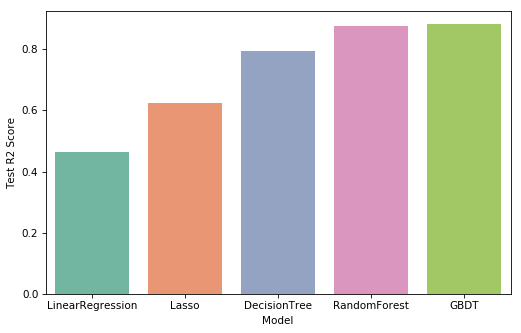

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5),dpi = 75)
sns.barplot(data = df, x = 'Model', y = 'Test R2 Score',palette='Set2')
plt.show()

# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


#### explore features distribution

In [12]:
train_test = pd.concat([x,y],1)
train_test.describe()

,is_open,latitude,longitude,review_count,stars,Alcohol,BikeParking,BusinessAcceptsCreditCards,Caters,GoodForKids,HasTV,NoiseLevel,OutdoorSeating,RestaurantsAttire,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,WiFi,DriveThru,WheelchairAccessible,CoatCheck,GoodForDancing,HappyHour,DogsAllowed,Smoking,sum
count,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.0,87.0,87.000000,87.000000,87.000000,87.000000,87.0,87.0,87.000000
mean,0.758621,41.483696,-81.624990,49.551724,3.528736,1.896552,0.436782,0.931034,0.379310,0.425287,0.609195,1.344828,0.390805,1.011494,0.172414,0.678161,0.574713,0.632184,0.862069,0.0,0.0,0.459770,0.034483,0.011494,0.172414,0.0,0.0,68.137931
std,0.430400,0.045309,0.086381,68.035517,0.748473,1.294303,0.498863,0.254864,0.488028,0.497253,0.490759,1.065610,0.490759,0.600276,0.379930,0.469890,0.497253,0.485006,0.346827,0.0,0.0,0.501268,0.183523,0.107211,0.379930,0.0,0.0,88.861425
min,0.000000,41.393525,-81.796835,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
25%,1.000000,41.457589,-81.698284,7.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,7.500000
50%,1.000000,41.497723,-81.642584,19.000000,3.500000,3.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,28.000000
75%,1.000000,41.503955,-81.564561,66.000000,4.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.0,0.0,92.000000
max,1.000000,41.611009,-81.467864,408.000000,5.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,0.0,0.0,353.000000


In [13]:
# R2 score on train/test data
from sklearn.metrics import r2_score, mean_squared_error
print('R2 score on training data:', r2_score(y_train_hat, y_train))
print('R2 score on testing data:', r2_score(y_test, y_test_hat))

R2 score on training data: 0.9982817811606917
R2 score on testing data: 0.8678057811196813


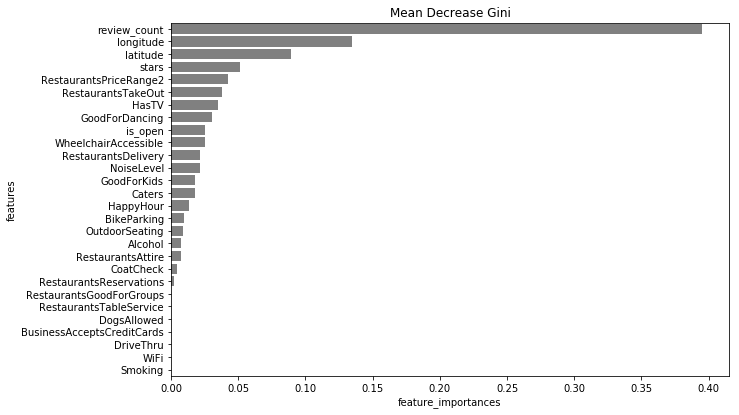

In [14]:
##Model feature importance bar plot
import seaborn as sns
feature_columns=list(x.columns)
feature_importances=model.feature_importances_
df_importance=pd.DataFrame(data={'features':feature_columns,
                   'feature_importances':feature_importances})
df_importance = df_importance.sort_values('feature_importances', ascending = False)
#plot
plt.figure(figsize=(10,6.5))
sns.barplot(x="feature_importances", 
            y="features", data=df_importance,
           color='grey')
plt.title('Mean Decrease Gini')
plt.show()

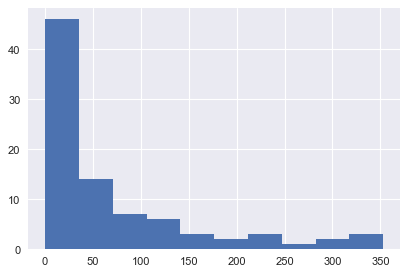

In [15]:
# distribution of target y 
plt.figure(figsize=(6,4),dpi = 80)
plt.style.use('seaborn')
y.hist()
plt.show()

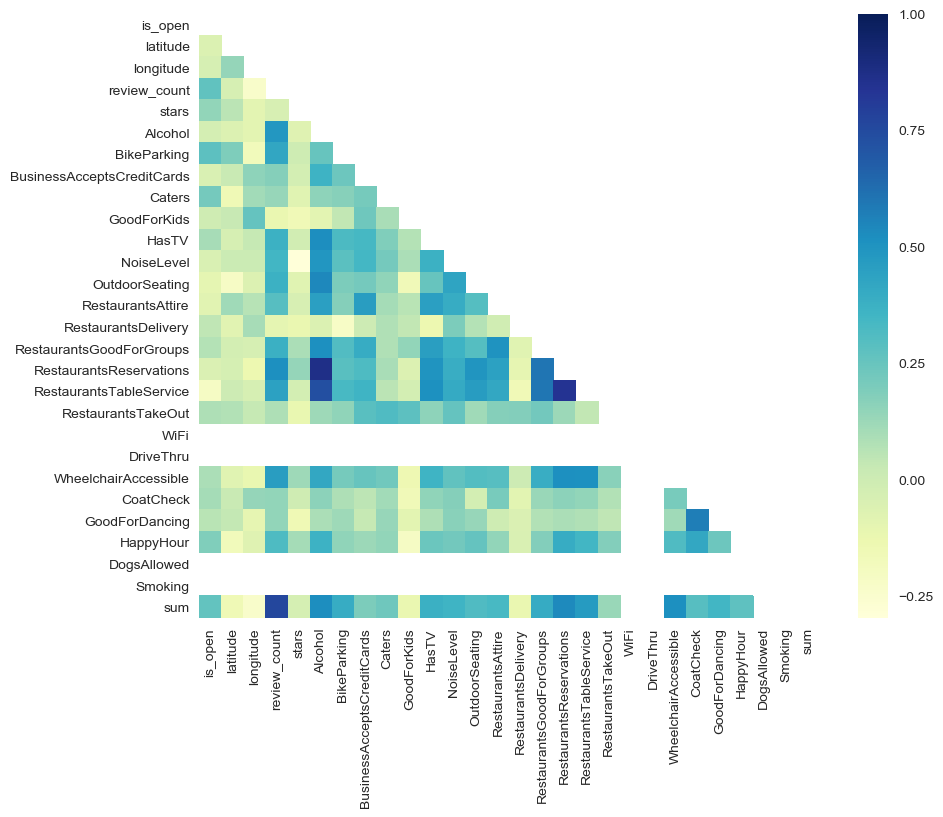

In [16]:
plt.figure(figsize=(10,8),dpi = 100)
train_test = pd.concat([x,y],1)
corrMatrix = train_test.corr()

mask = np.zeros_like(corrMatrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(corrMatrix,mask=mask, cmap="YlGnBu")
plt.show()

In [24]:
over3 = corrMatrix > 0.3
over3

,is_open,latitude,longitude,review_count,stars,Alcohol,BikeParking,BusinessAcceptsCreditCards,Caters,GoodForKids,HasTV,NoiseLevel,OutdoorSeating,RestaurantsAttire,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,WiFi,DriveThru,WheelchairAccessible,CoatCheck,GoodForDancing,HappyHour,DogsAllowed,Smoking,sum
is_open,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
latitude,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
longitude,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
review_count,False,False,False,True,False,True,True,False,False,False,True,True,True,False,False,True,True,True,False,False,False,True,False,False,True,False,False,True
stars,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Alcohol,False,False,False,True,False,True,False,True,False,False,True,True,True,True,False,True,True,True,False,False,False,True,False,False,True,False,False,True
BikeParking,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True
BusinessAcceptsCreditCards,False,False,False,False,False,True,False,True,False,False,True,True,False,True,False,True,True,True,False,False,False,False,False,False,False,False,False,False
Caters,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
GoodForKids,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [30]:
over3 = corrMatrix > 0.3
over3
d = {}
for i in range(len(over3.index)):
    for j in range(len(over3.columns)):
        if (over3.values[i,j] == True) and (over3.index[i] != over3.columns[j]):
            d[over3.index[i]] = over3.columns[j]
                       

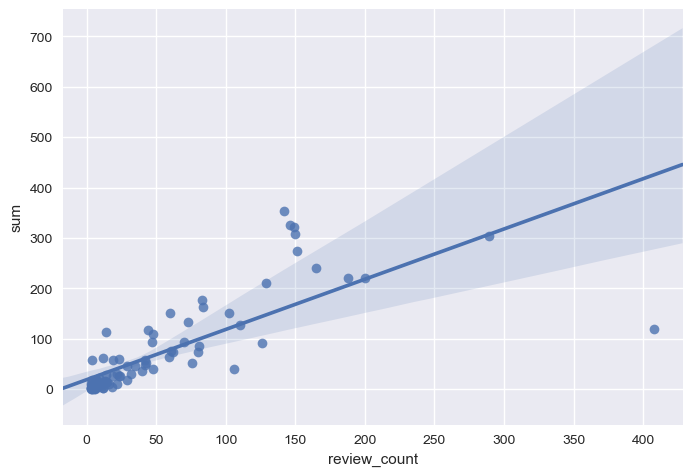

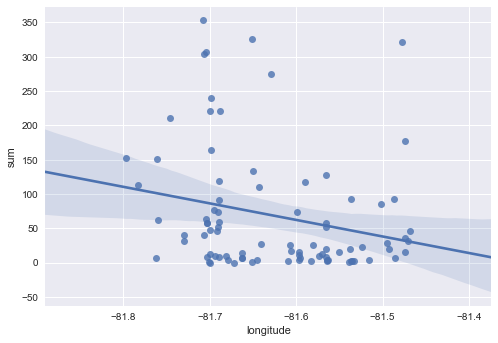

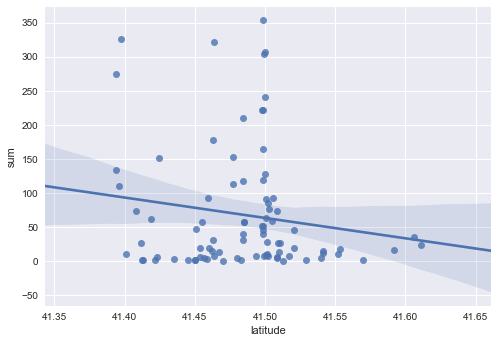

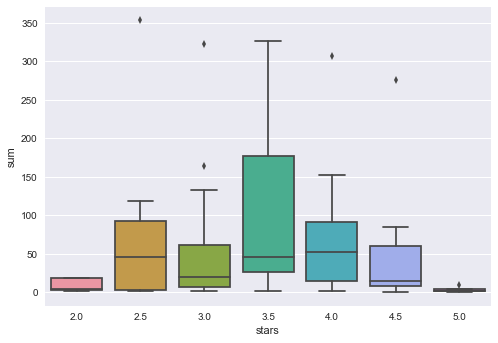

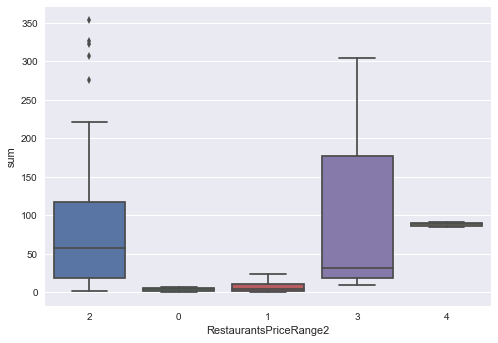

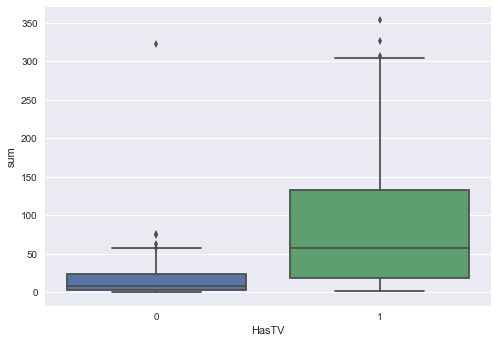

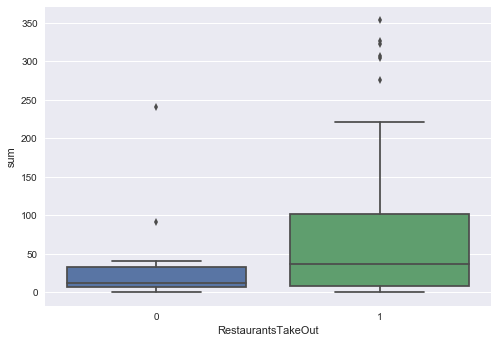

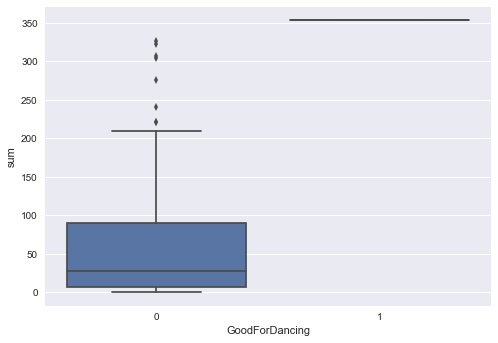

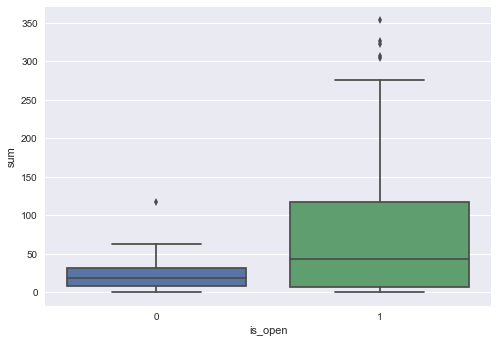

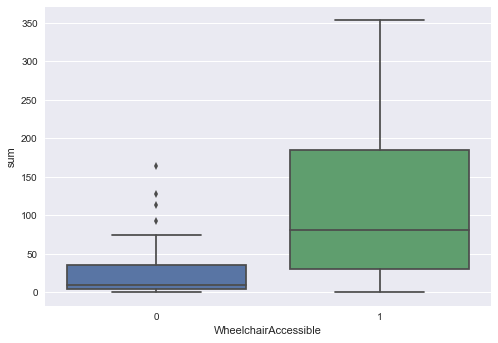

In [36]:
top10_features = df_importance.features.values[0:10]
plt.figure(dpi = 100)
for f in top10_features:
    if f in ['review_count','latitude','longitude']:
        sns.regplot(x=f, y='sum', data = toronto_restaurants_df)
        plt.show()
    else:
        sns.boxplot(x=f, y='sum', data = toronto_restaurants_df)
        plt.show()

*-----------------
# Done

All set! 

** What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "jupyter notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides (for 7 minutes' talk) to present about the case study . Each team present their case studies in class for 7 minutes.

Please compress all the files in a zipped file.


** How to submit: **

        Please submit through Canvas, in the Assignment "Case Study 2".
        
** Note: Each team only needs to submit one submission in Canvas **